In [13]:
!pip install fastapi uvicorn pydantic motor
!pip install scikit-learn
!pip install openpyxl



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\hengl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\hengl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\hengl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [14]:
from fastapi import FastAPI, HTTPException, Body
from pydantic import BaseModel
from motor.motor_asyncio import AsyncIOMotorClient

# MongoDB connection string
MONGODB_URL = "mongodb://localhost:27017"
DATABASE_NAME = "employee_db"
COLLECTION_NAME = "employees"

# FastAPI instance
app = FastAPI()

# Pydantic model for Employee
class Employee(BaseModel):
    name: str
    age: int
    department: str

# MongoDB connection setup
client = AsyncIOMotorClient(MONGODB_URL)
db = client[DATABASE_NAME]
collection = db[COLLECTION_NAME]

# Routes
@app.post("/employees/", response_model=Employee)
async def create_employee(employee: Employee = Body(...)):
    # Check if employee with same name already exists
    existing_employee = await collection.find_one({"name": employee.name})
    if existing_employee:
        raise HTTPException(status_code=400, detail="Employee with this name already exists")
    
    # Insert new employee
    result = await collection.insert_one(employee.dict())
    created_employee = await collection.find_one({"_id": result.inserted_id})
    return created_employee

@app.get("/employees/", response_model=list[Employee])
async def read_employees():
    employees = []
    async for employee in collection.find():
        employees.append(employee)
    return employees

@app.put("/employees/{employee_id}/", response_model=Employee)
async def update_employee(employee_id: str, employee: Employee = Body(...)):
    # Update existing employee
    await collection.update_one({"_id": employee_id}, {"$set": employee.dict()})
    updated_employee = await collection.find_one({"_id": employee_id})
    if updated_employee:
        return updated_employee
    raise HTTPException(status_code=404, detail="Employee not found")

@app.delete("/employees/{employee_id}/", response_model=dict)
async def delete_employee(employee_id: str):
    # Delete employee
    delete_result = await collection.delete_one({"_id": employee_id})
    if delete_result.deleted_count == 1:
        return {"message": "Employee deleted successfully"}
    raise HTTPException(status_code=404, detail="Employee not found")


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# **Data Extraction**

**Import Dataset** : *https://www.kaggle.com/code/ronaldopangarego/e-commerce-customer-churn-analysis-and-prediction*

In [16]:
data1 = pd.read_excel("C:/Users/hengl/Downloads/E Commerce Dataset (1).xlsx")

In [17]:
data1.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


# **Data** **Cleaning**

**Duplicated Values**

In [18]:
#checking for duplicated values in the dataset
data1.duplicated().sum()

0

There is no duplicated data in this dataset. Even in customerID features.

**Unwanted Datapoint**

In [19]:
#dropping unwanted columns ["CustomerID"]
del data1["CustomerID"]

CustomerID column is removed as it doesn't have any predictive value. It typically serves as a unique identifier for each customer.

**Missing Data**

In [22]:
#checking missing values in dataset
total_na = data1.isnull().sum().sum()
print(f"Total missing values: {total_na} ({ round((total_na/data1.shape[0])*100, 2) }%)")

data1.isnull().sum()

Total missing values: 1856 (32.97%)


Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

We have total of 1856 of missing values, it's about 32.97% from total data

Text(0.5, 1.0, 'Quantifying missing data')

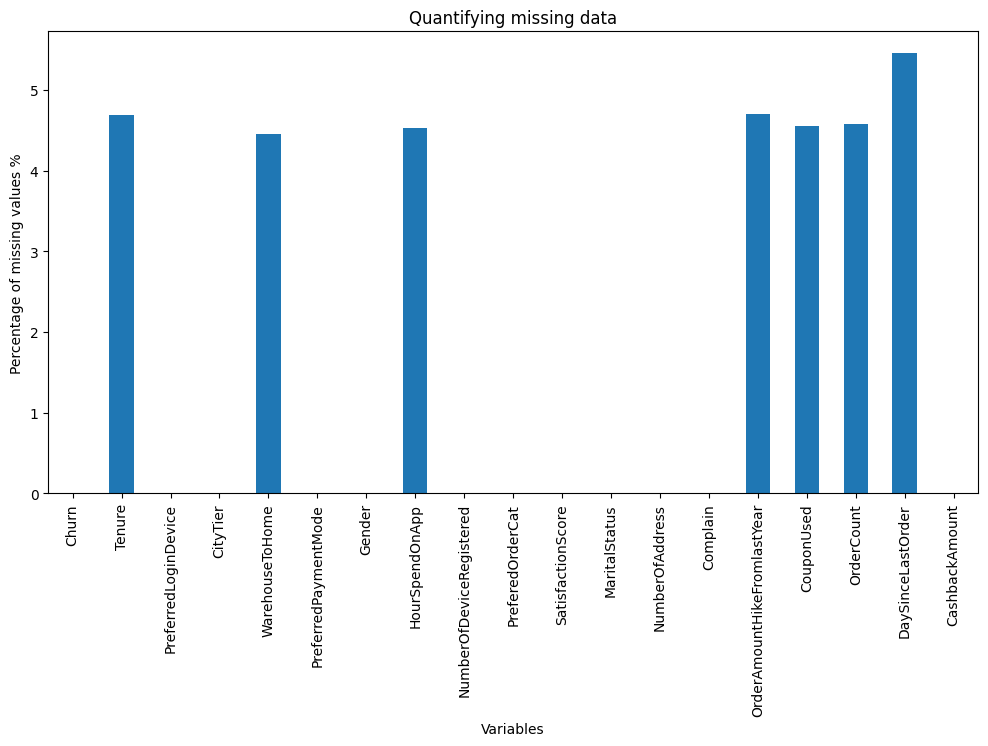

In [23]:
#showing percentage of missing data in histogram
(data1.isnull().mean()*100).plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values %')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [24]:
data1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.0000,1.00
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.00,15.00,18.0000,26.00


There is not really a difference between the mean and median in each column. Therefore, we decided to fill in all the missing values with median as some feature might make more sense if it had integer values, like Complain, CouponUsed, OrderCount, etc., (because there is nothing likes "Customer used coupon 1.75 times” or “Customer has 0.2 complained")

**Filling in missing data with median**

In [107]:
#fill in missing values
for col in data1.columns:
    if data1[col].isnull().sum() > 0:
        data1[col].fillna(data1[col].median(), inplace=True)

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1607026717.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data1[col].fillna(data1[col].median(), inplace=True)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1607026717.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [26]:
#validation
data1.isnull().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

Now, there is no more missing values in our dataset

**Identifying Outliers**

In [27]:
#get info of the dataset
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  Complain          

We then check the outliers for numerical variables which is values with int64 or float64

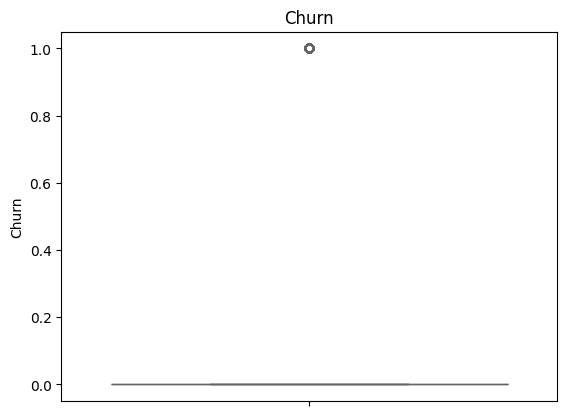

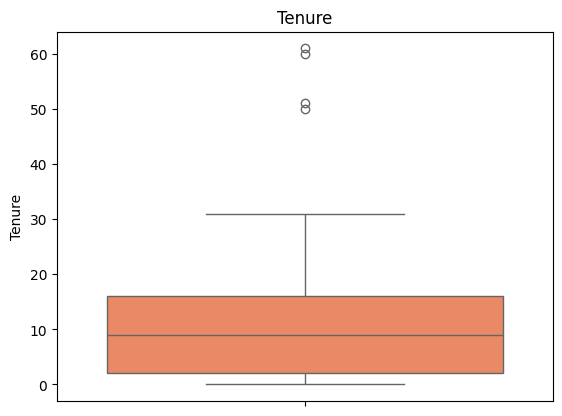

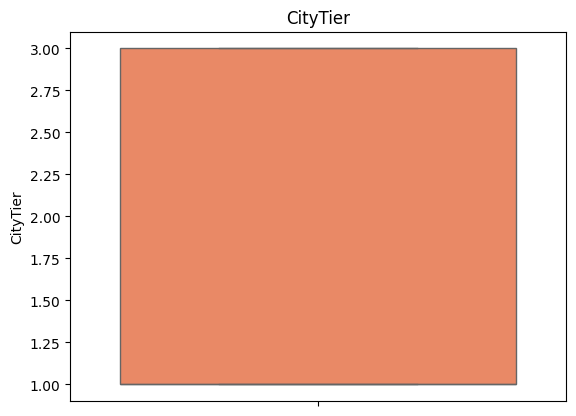

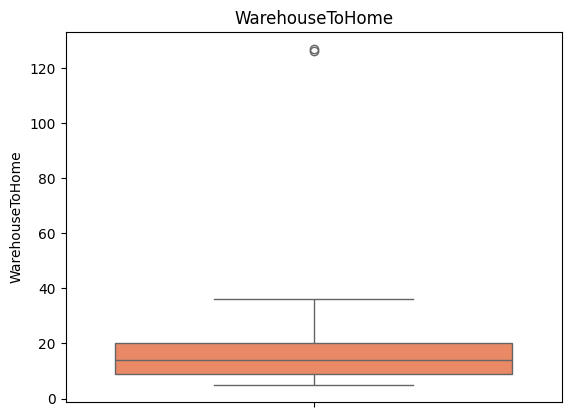

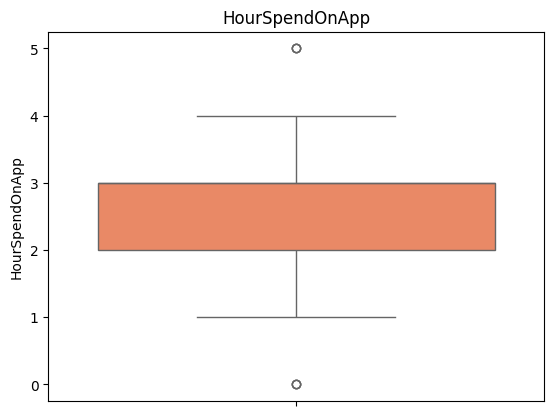

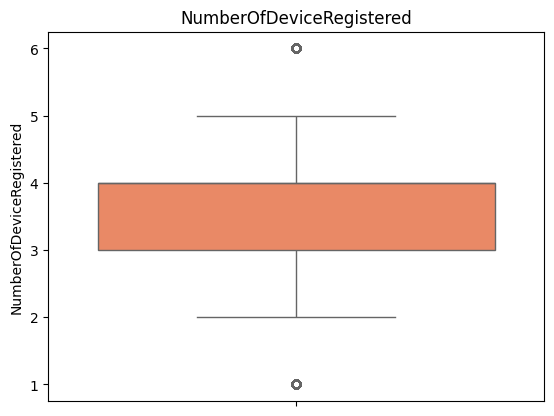

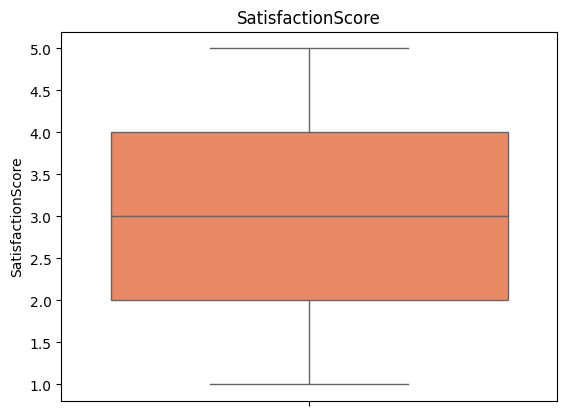

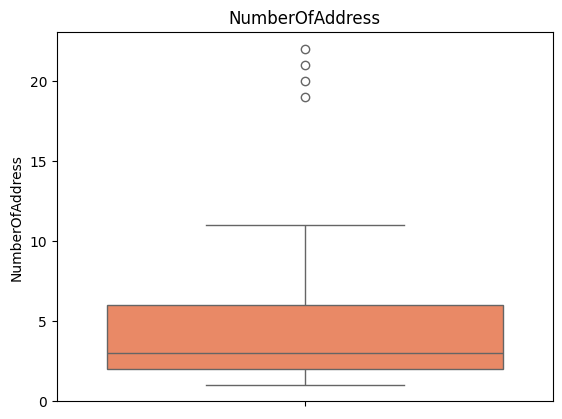

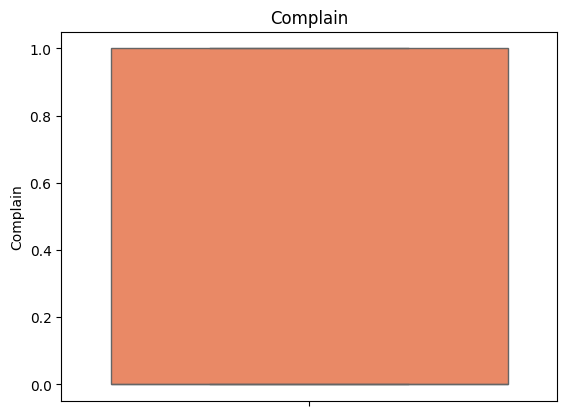

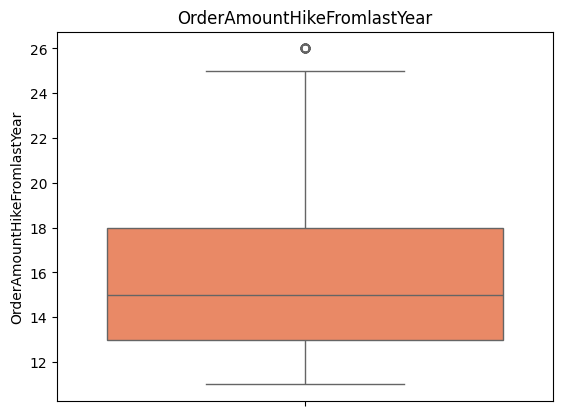

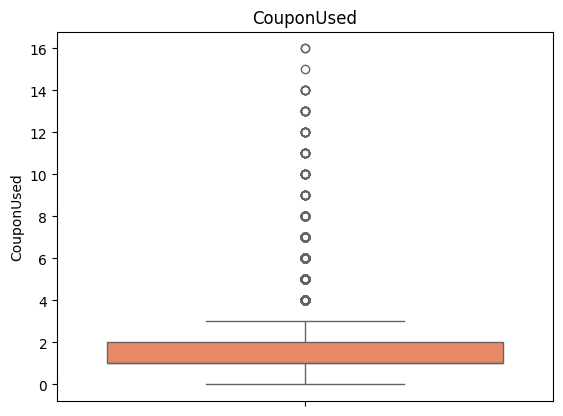

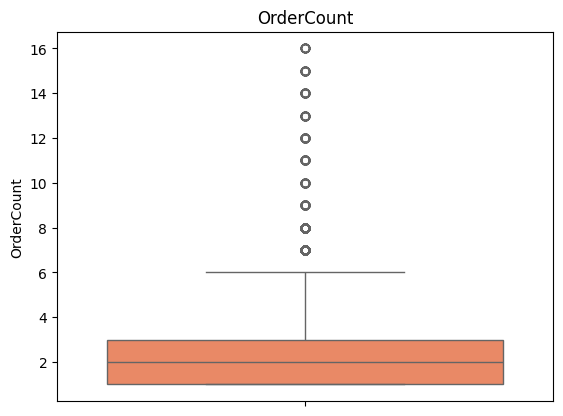

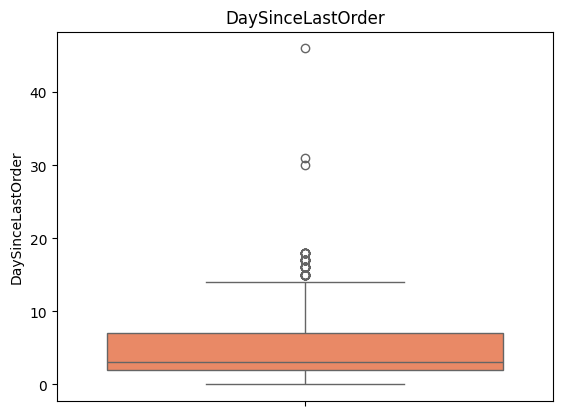

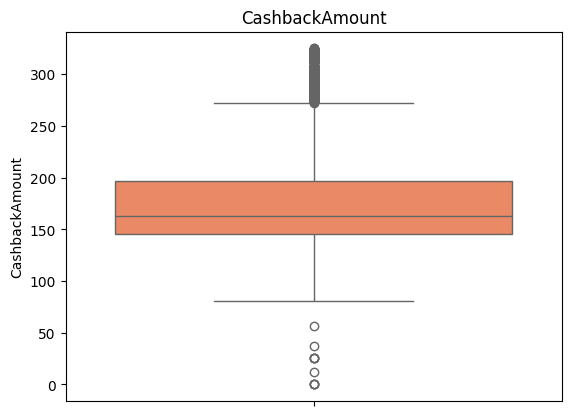

In [28]:

# Loop over the columns in the DataFrame and show each as a box plot
for i in data1.columns:
  if data1[i].dtype in ['int64', 'float64']:
    plt.title(i)
    sns.boxplot(data=data1[i], color='#FF7F50')
    plt.show()

In summary, we can see that these particular columns contained outliers

*   Tenure
*   WarehouseToHome
*   NumberOfAddress
*   OrderAmountHikeFromlastYear
*   CouponUsed
*   OrderCount
*   DaySinceLastOrder
*   CashbackAmount

CashbackAmount feature relatively has high significance number of outliers compared to others.

In [29]:
data2=data1.copy()

We will using IQR methods to solve the outliers on CashbackAmount column

In [30]:
column_name = "CashbackAmount"

In [31]:
# Calculate the IQR (Interquartile Range) for the specified column
Q1 = data2[column_name].quantile(0.25)
Q3 = data2[column_name].quantile(0.75)
IQR = Q3 - Q1

In [32]:
# calculating the cutoff value using 1.5 times the IQR
cutoff = 1.5 * IQR
# calculating the lower limit using the first quartile minus the cutoff value
lower = Q1 - cutoff
# calculating the upper limit using the third quartile value plus the cutoff value
upper = Q3 + cutoff

In [33]:
# printing the lower and upper limits
print(f'The Lower Limit is : {lower}, The Upper Limit is : {upper}')

The Lower Limit is : 69.83625, The Upper Limit is : 272.32625


In [34]:
# printing the number of values that is above the upper limits and below the lower limits
print('The Number of Above Upper Limits :' ,len(data2[data2['CashbackAmount'] > upper]))
print('The Number of Below Lower Limits :' ,len(data2[data2['CashbackAmount'] < lower]))

The Number of Above Upper Limits : 427
The Number of Below Lower Limits : 11


**Handling Outliers**

In [35]:
#calculate the median of the 'CashbackAmount' column
median = np.median(data2['CashbackAmount'])

In [36]:
#replace outliers with median
data2['CashbackAmount'] = np.where(data2['CashbackAmount'] > upper, median, data2['CashbackAmount'])

In [37]:
data=data2.copy()

In [38]:
data.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


Now, the outliers has been solved for the 'CashbackAmount' columns and yet the whole process of data cleaning is done

# **Data Exploration**

**Overview of data structure and shape**

In [39]:
# printing shape of the dataset (rows, columns)
data.shape

(5630, 19)

It consists on 5630 rows and 19 columns after dropping the 'CustomerID' during data cleaning

In [40]:
# get the datatypes that exists in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  Complain          

 **Compute the mean, sum, range, and other interesting statistics for numeric
columns.**

In [41]:
data.describe()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,166.953723
std,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,34.585083
min,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.255000
75%,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,182.437500
max,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,272.320000


**Distribution of numerical columns**

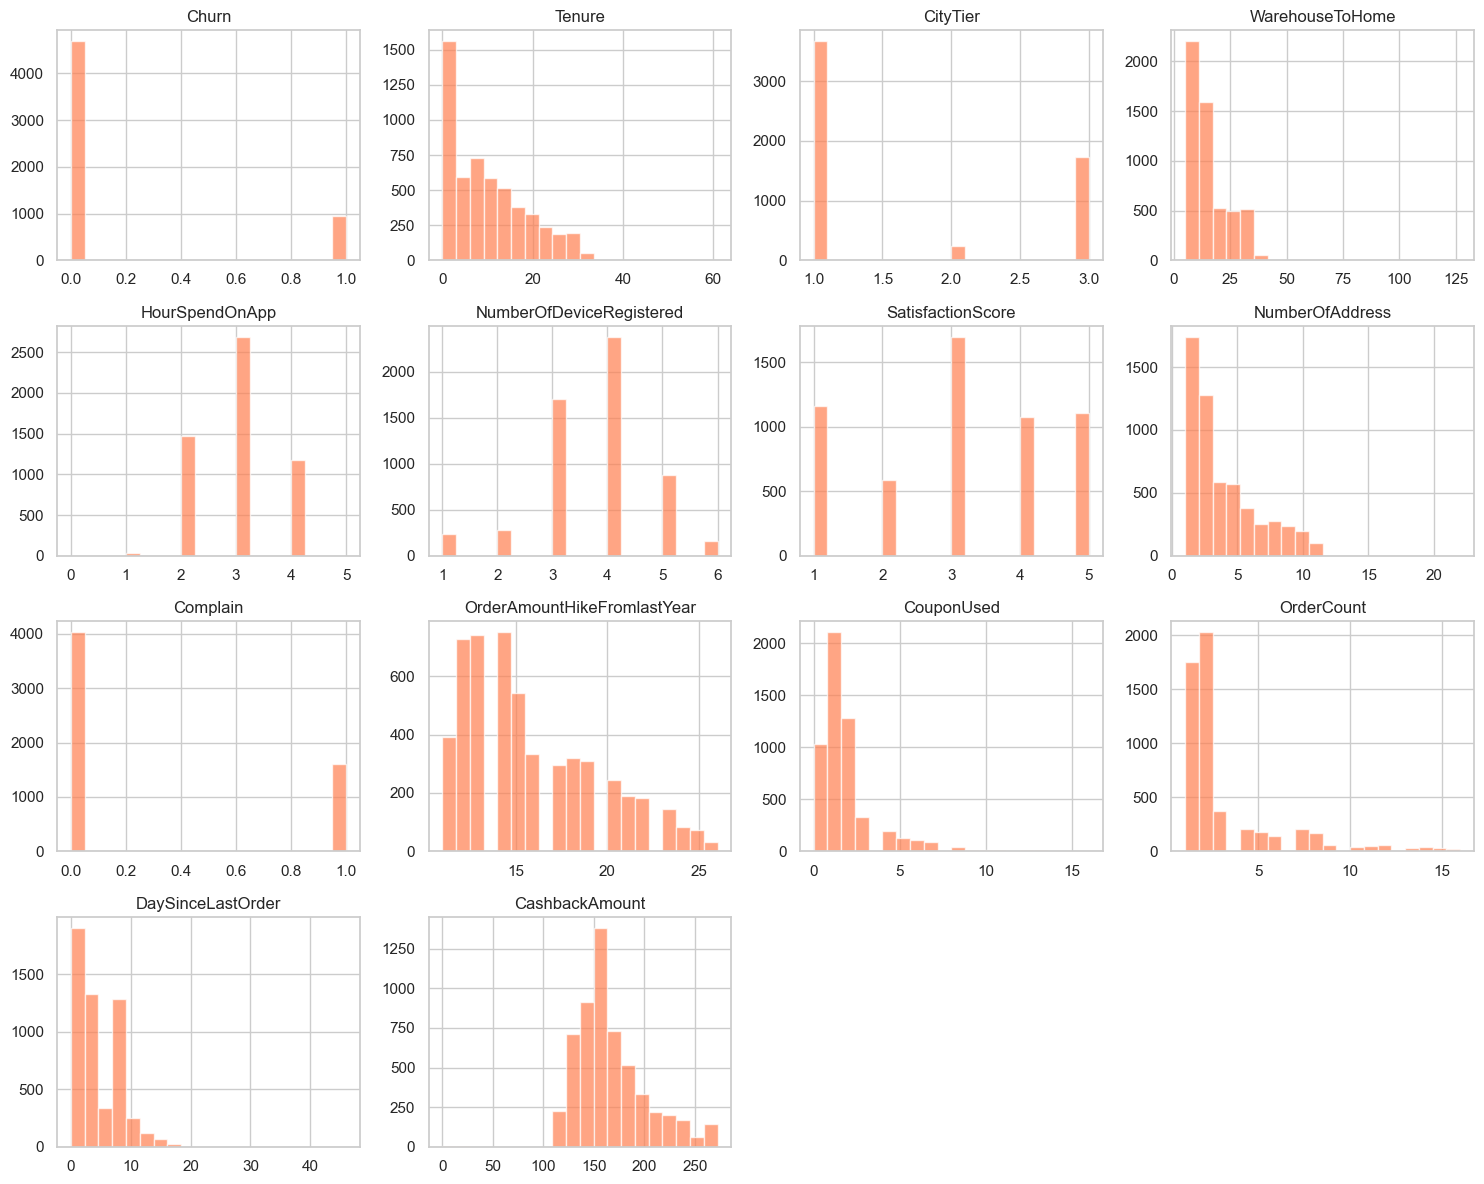

In [85]:
import matplotlib.pyplot as plt

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Create subplots to display multiple histograms
num_numerical_columns = len(numerical_columns)
num_rows = (num_numerical_columns - 1) // 4 + 1  # 4 histograms per row
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(15, 3 * num_rows))

# Plot histograms for each numerical column
for i, col in enumerate(numerical_columns):
    ax = axes[i // 4, i % 4]
    ax.hist(data[col], bins=20, color='#FF7F50', alpha=0.7)
    ax.set_title(col)

# Remove any unused subplots
for i in range(num_numerical_columns, num_rows * 4):
    fig.delaxes(axes[i // 4, i % 4])

# Improve layout
plt.tight_layout()
plt.show()


**Relationship between numerical columns**

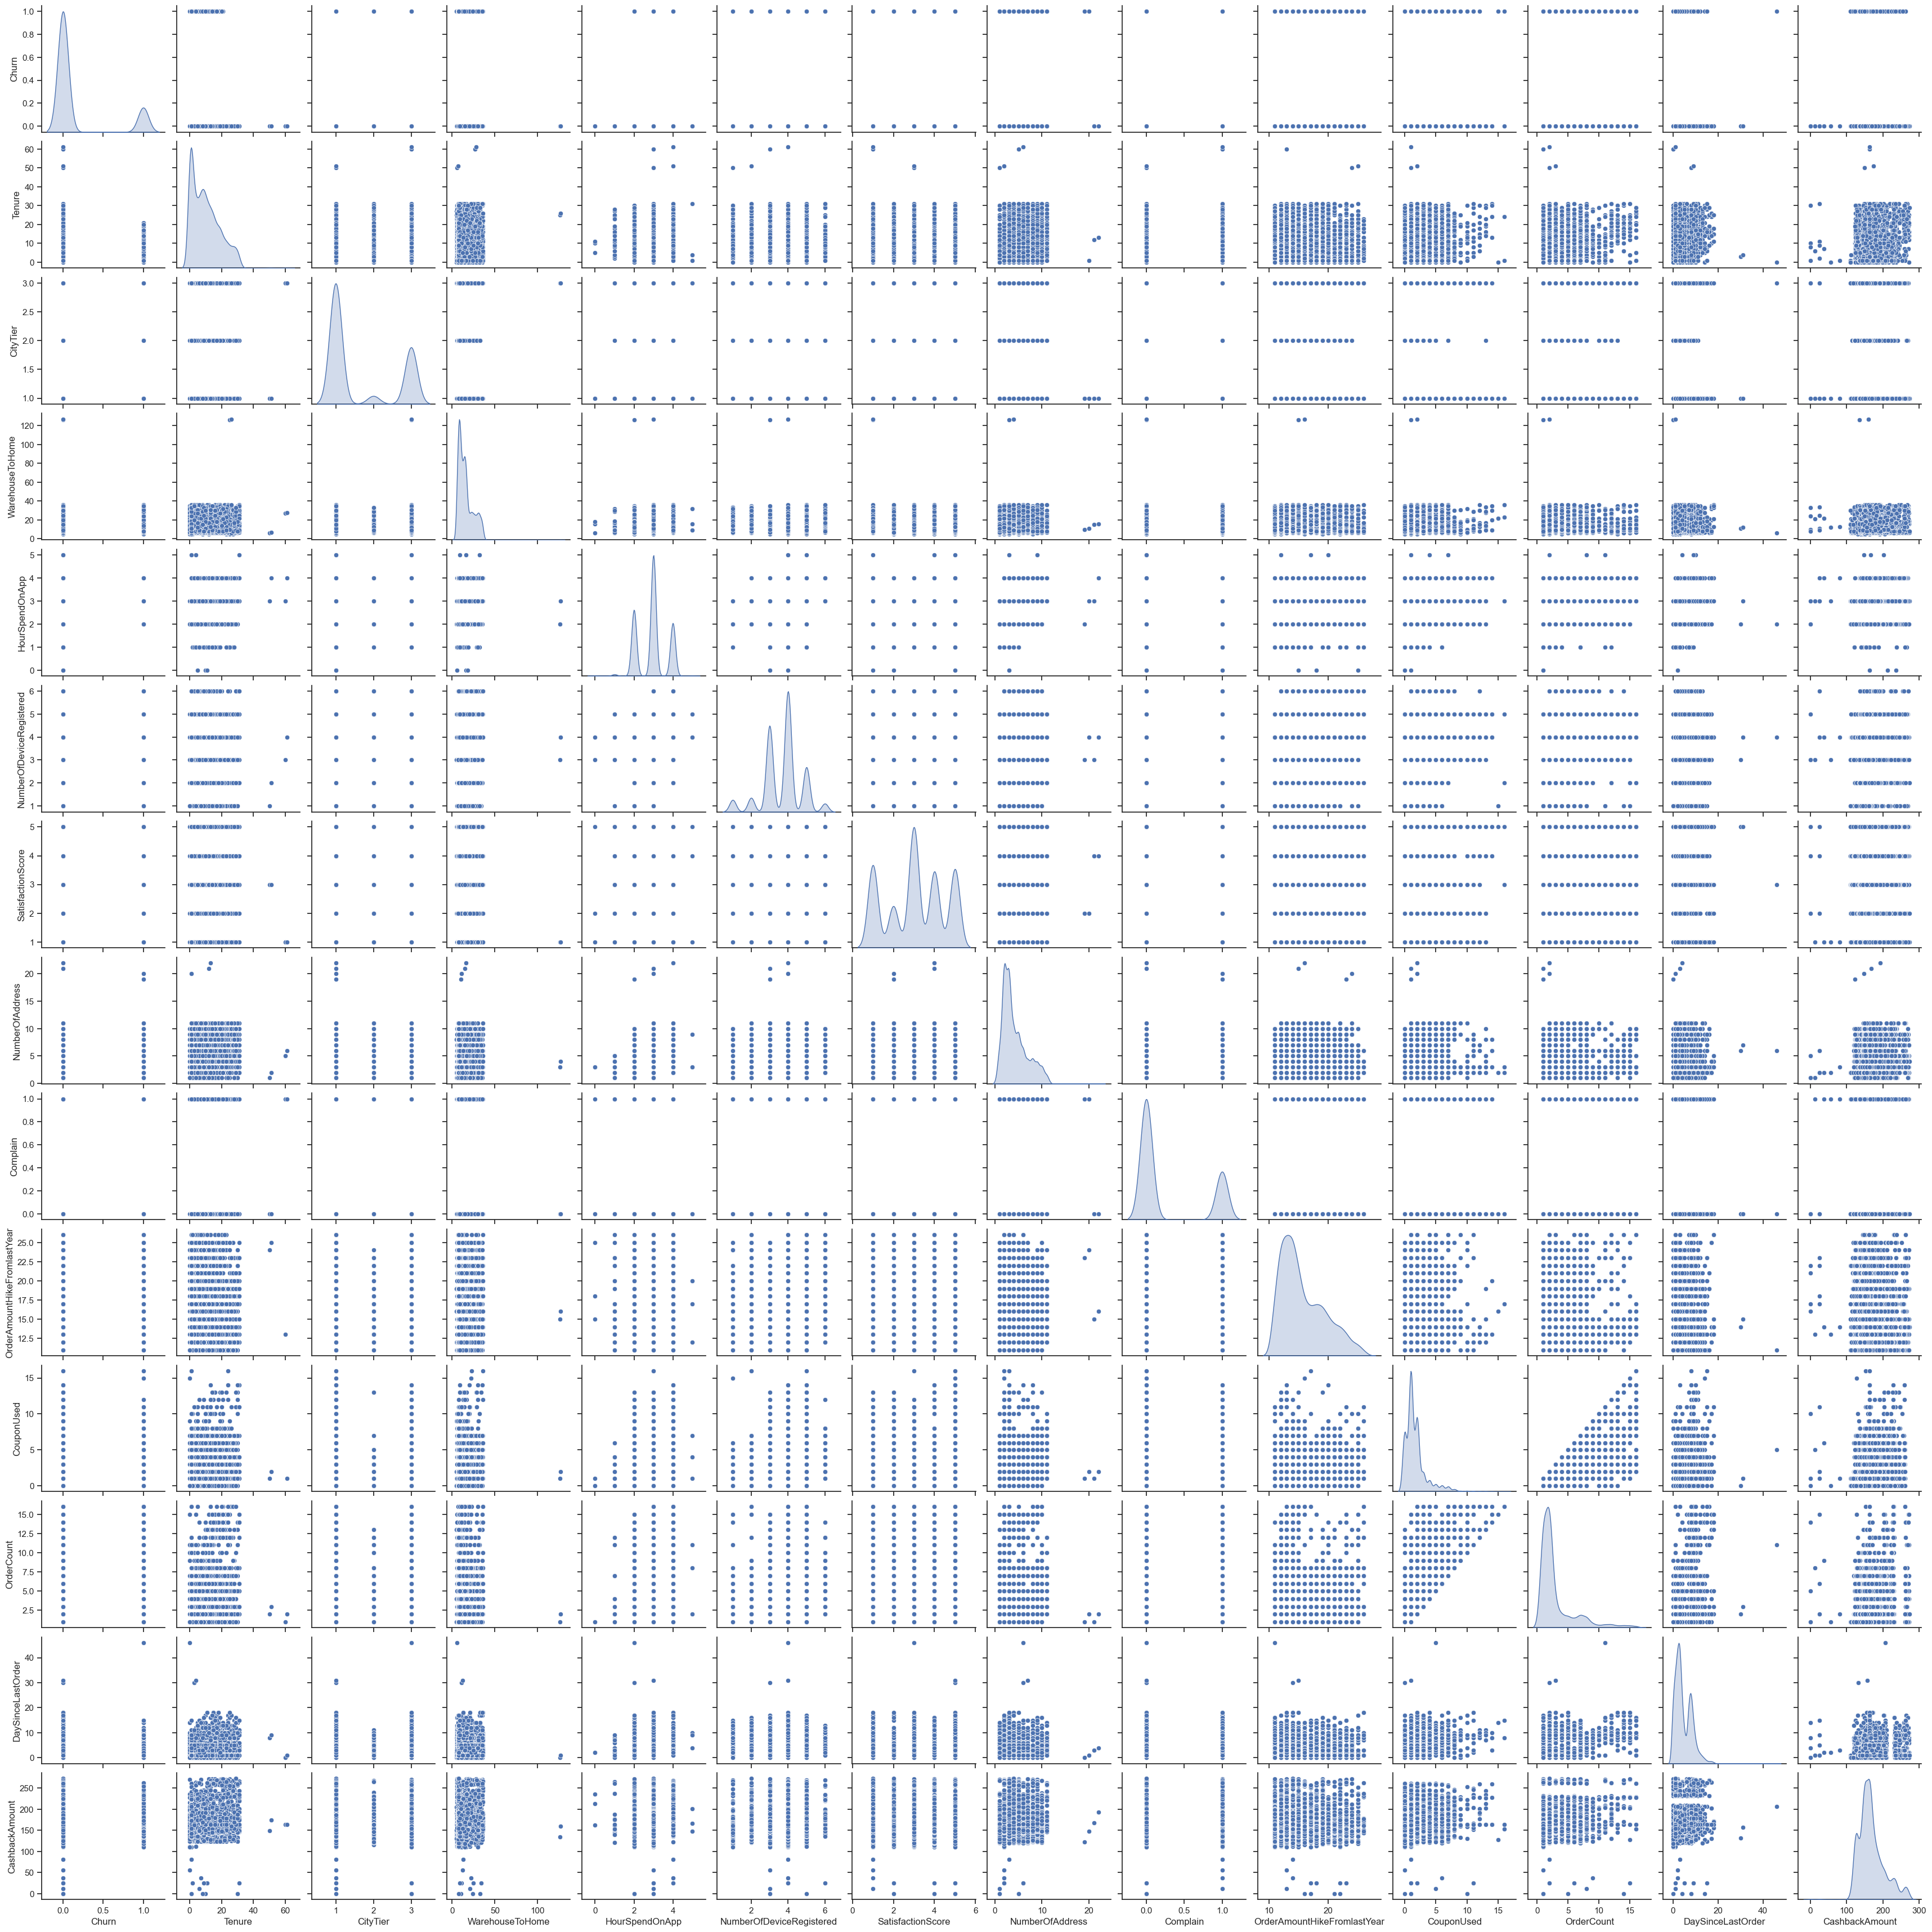

In [86]:
# Set the style and color palette for the pairplot
sns.set(style="ticks")
# Create a pairplot for numerical columns with scatter plots on the lower diagonal and kernel density estimates on the diagonal
sns.pairplot(data[numerical_columns], kind='scatter', diag_kind='kde')
#show the pairplot
plt.show()

**Relationship between categorical columns**

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


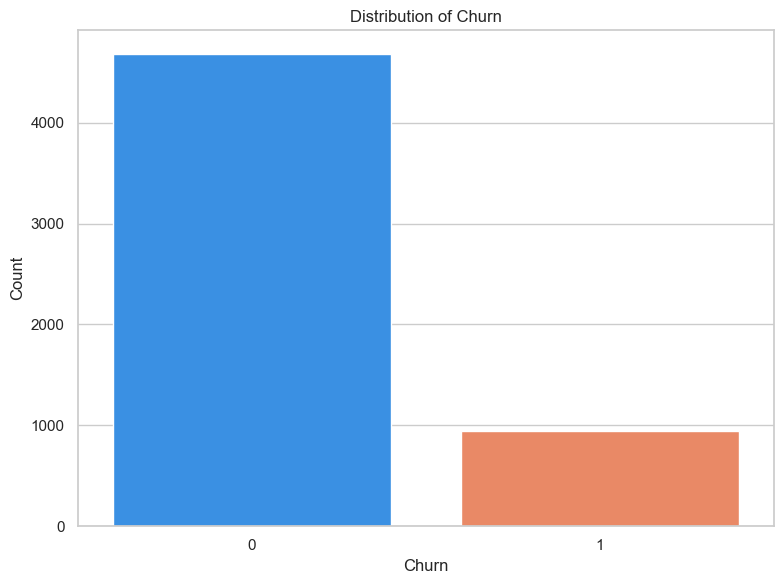

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


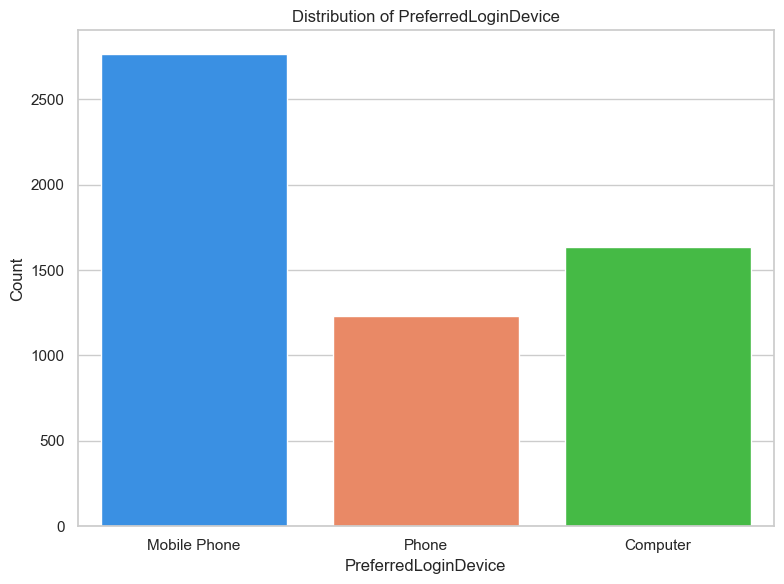

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


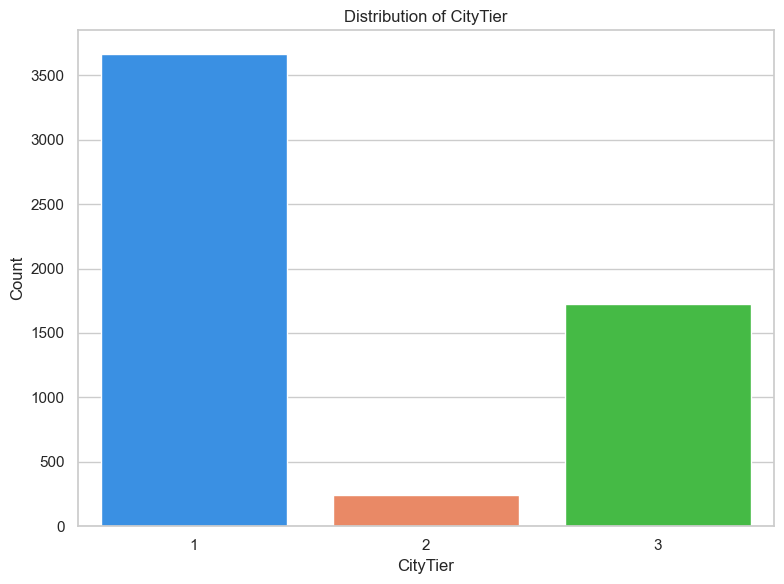

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


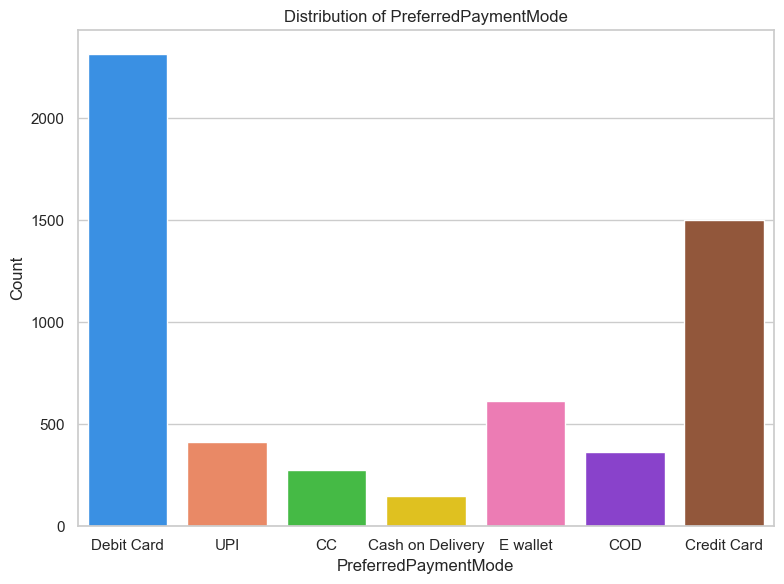

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


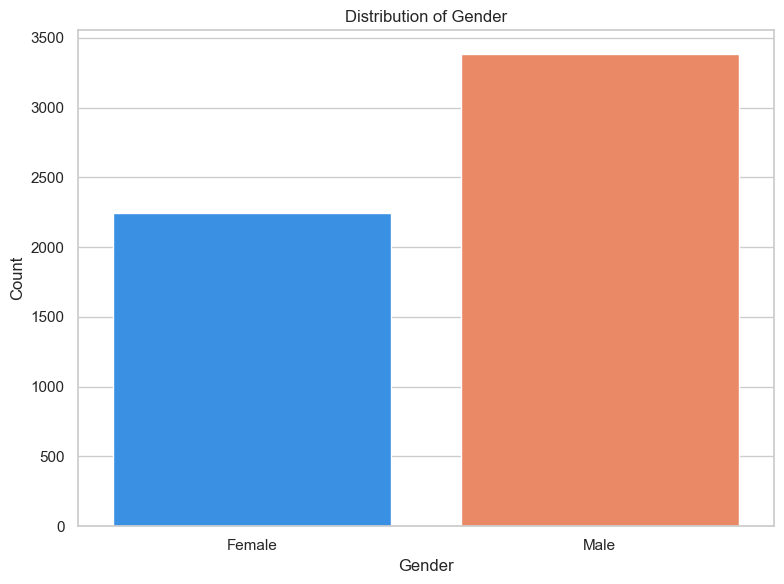

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


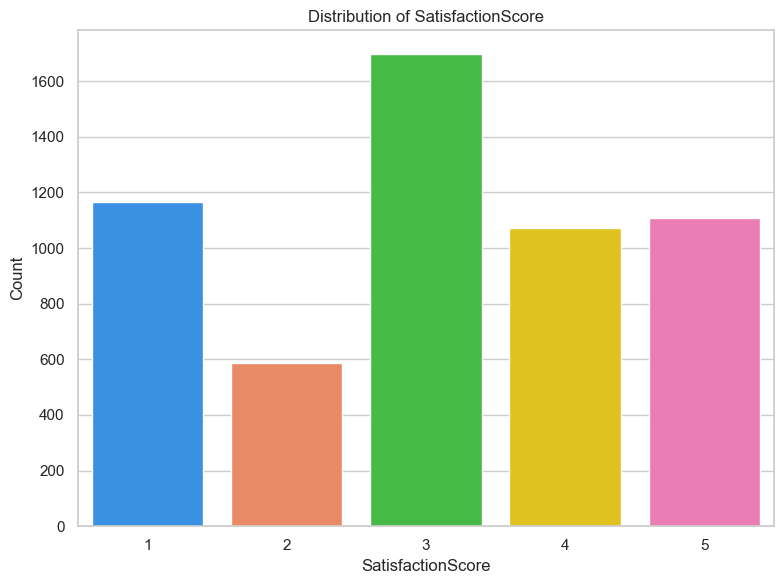

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


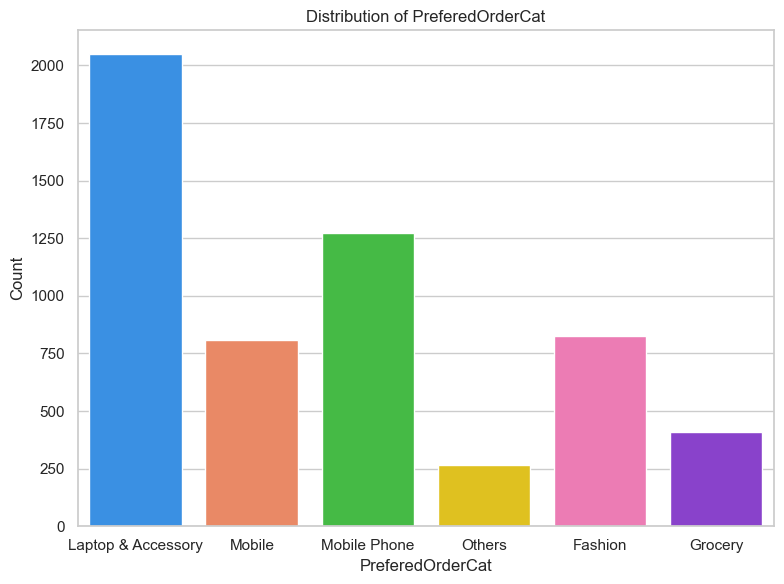

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


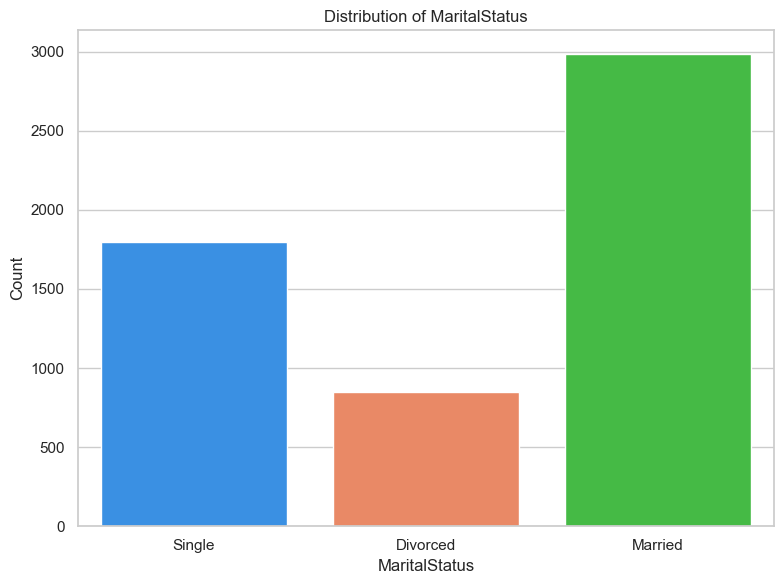

C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=col, palette=color_theme)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25188\1337590559.py:12: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.countplot(data=data, x=col, palette=color_theme)


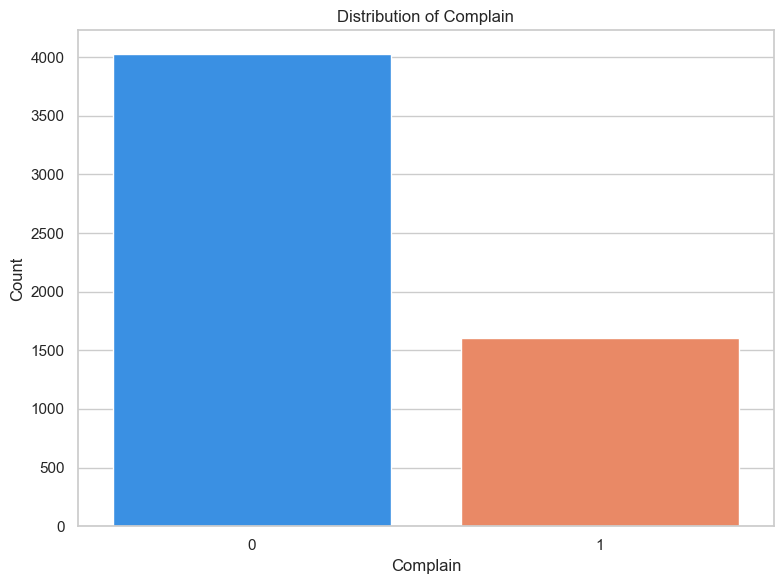

In [87]:
# Define custom color palette
color_theme = ['#1E90FF','#FF7F50', '#32CD32', '#FFD700', '#FF69B4', '#8A2BE2', '#A0522D', '#5F9EA0', '#D2691E']

# Categorical columns
categorical_columns = ['Churn', 'PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'SatisfactionScore', 'PreferedOrderCat', 'MaritalStatus', 'Complain']

# Create bar charts for each categorical column
sns.set(style="whitegrid")

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=col, palette=color_theme)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In our research, the primary objective is to predict customer churn. To gain a deeper understanding of the factors influencing churn.This phase involves scrutinizing each attribute or column in our dataset and its relationship with our target variable, 'Churn.' Our aim is to unveil patterns, trends, and correlations that may provide valuable insights into customer behavior and churn prediction.

Now, a new question arise which is 'What factors caused our customer retent and turn into company Y',so we will focusing on our target Churn and how they related to other features


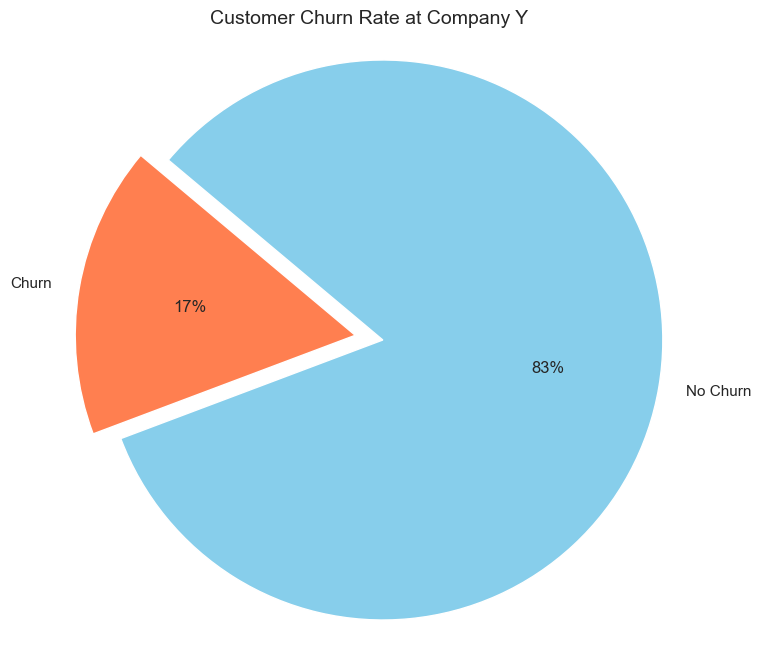

In [45]:
# Calculate churn and no-churn counts
churn_count = (data['Churn'] == 1).sum()
no_churn_count = (data['Churn'] == 0).sum()

# Labels for the pie chart
labels = ['Churn', 'No Churn']

# Colors for the pie chart
colors = ['#FF7F50', '#87CEEB']

# Explode a slice if needed
explode = (0.1, 0)  #

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie([churn_count, no_churn_count], labels=labels, colors=colors, autopct='%.0f%%', explode=explode, startangle=140)
plt.title('Customer Churn Rate at Company Y', size=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the chart
plt.show()

It can be clearly seen that the distribution of customers who retained or no churn are relatively higher than the customers who churn in the dataset. It indicates an imbalanced dataset here. Rest assured, we will handle the imbalanced dataset soon by the oversampling method.

Now, we are going to segmenting our dataset into three distinct feature categories which are Customer Demography, Customer Purchasing Behavior, and Customer Compliance. The reason behind this is they eventually allows us to gain a holistic understanding of the factors influencing customer churn.Customer Demography provides insights into who the customers are for Company Y, while Customer Purchasing Behavior reveals how they interact with the platform. Customer Compliance highlights key metrics, such as satisfaction and complaints, which impact the customers' loyalty.

In [46]:
# Segmentation 1- Customer Demography
customer_demo = [ 'CityTier', 'Gender', 'MaritalStatus', 'NumberOfAddress', 'NumberOfDeviceRegistered','WarehouseToHome']
# Segementation 2- Customer Purchasing Behaviour
customer_behv = [ 'Tenure', 'PreferredLoginDevice', 'PreferredPaymentMode', 'HourSpendOnApp', 'PreferedOrderCat', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
            'DaySinceLastOrder', 'CashbackAmount']
# Segmentation 3- of Customer Compliance
customer_compl = ['SatisfactionScore', 'Complain']

**Customer Demographies Exploration**

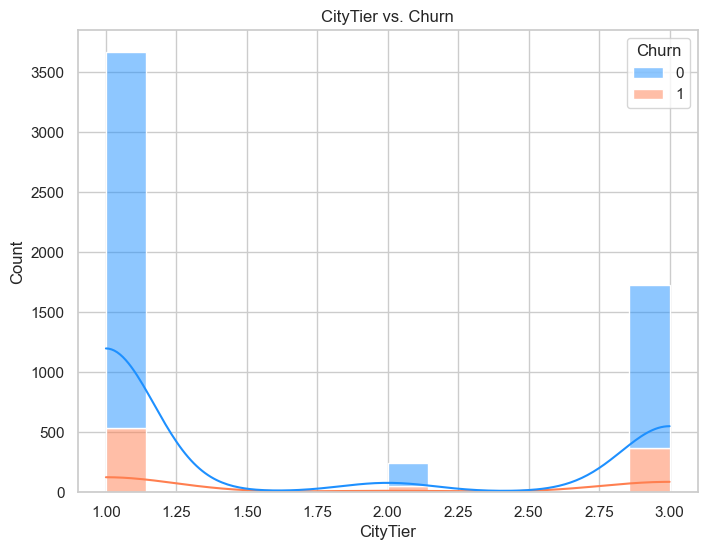

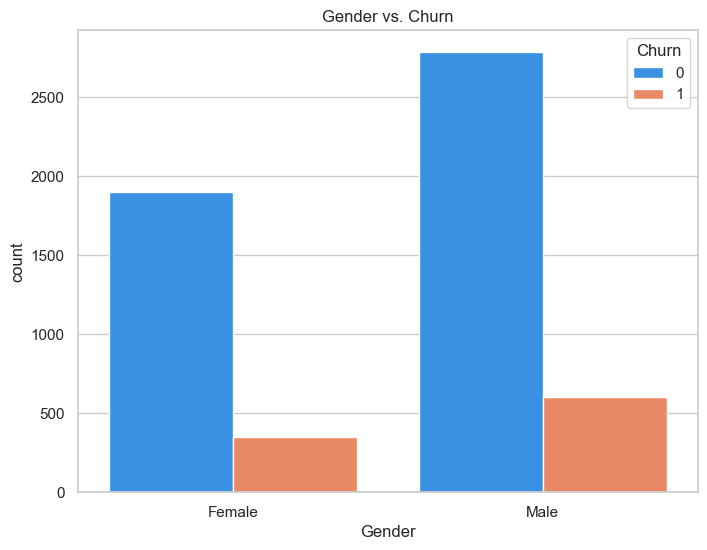

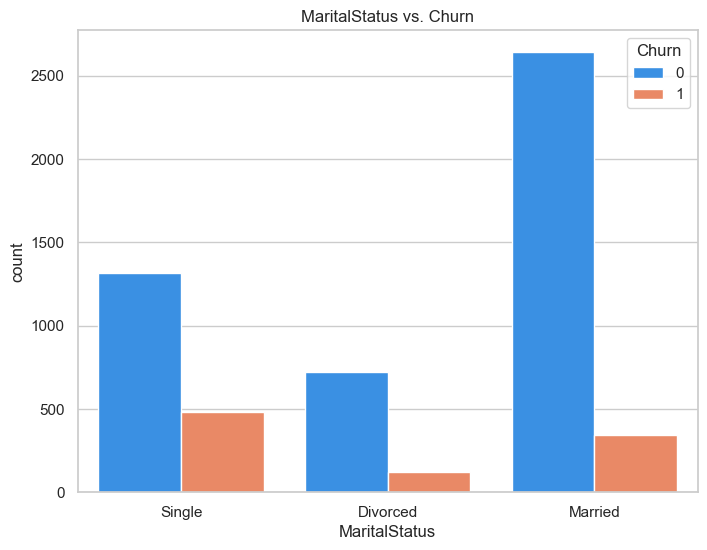

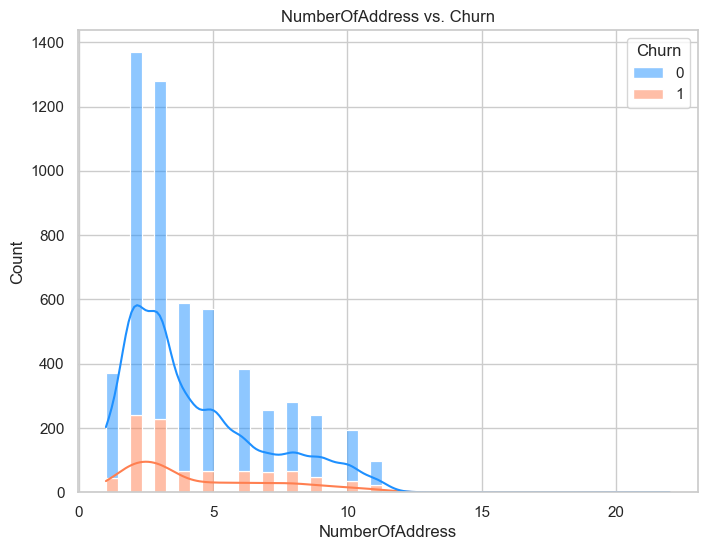

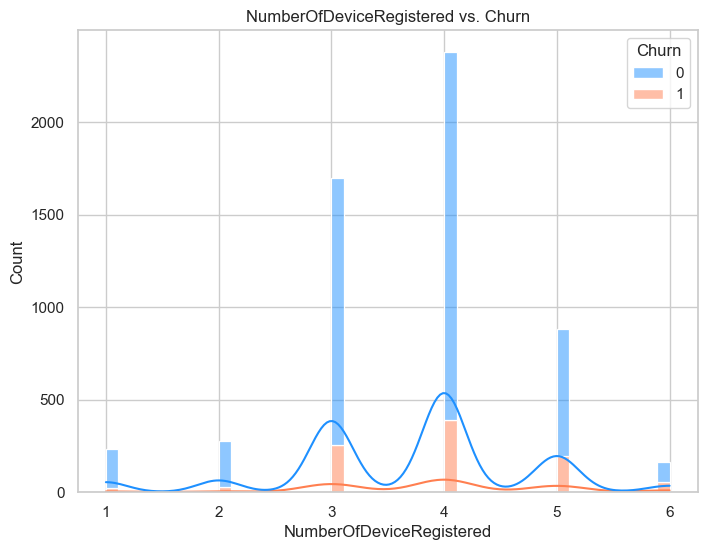

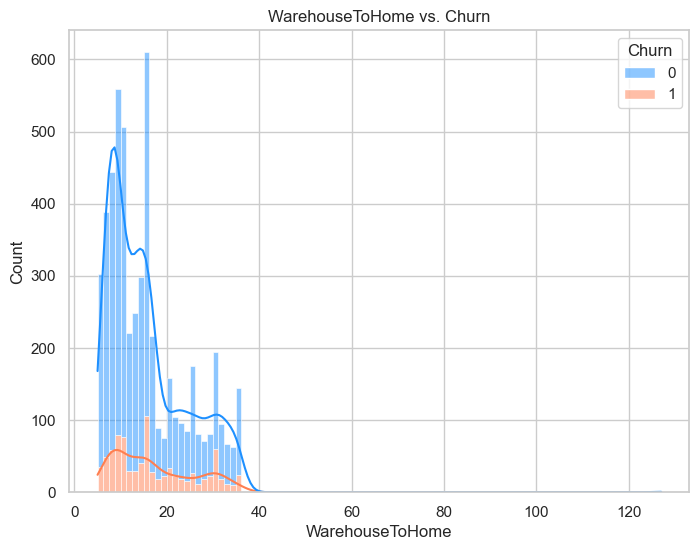

In [47]:
# Define custom color palette
color_theme = ['#1E90FF','#FF7F50']

# Loop over the features in the 'custdemo' dataframe and plot data based on datatype
for feature in data[customer_demo].columns:
    # Check the datatype of the feature
    if data[feature].dtype == 'object':
        # Create a countplot for categorical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.countplot(data=data, x=feature, hue='Churn', dodge=True)
        plt.title(f'{feature} vs. Churn')
    else:
        # Create a histogram with kernel density estimate for numerical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.histplot(data=data, x=feature, hue='Churn', multiple='stack', kde=True)
        plt.title(f'{feature} vs. Churn')
    plt.show()


Insights:

**CityTier**: The data suggests that the likelihood of churn is more prevalent among customers residing in City Tier 1.

**Gender**: It appears that male customers have a higher frequency of churn compared to female customers.

**MaritalStatus**: The data indicates that single customers are more likely to experience churn.

**NumberOfAddress**: The frequency of churn is higher among customers with either 2 or 3 addresses.

**NumberOfDeviceRegistered**: Churn is more frequent among customers who have registered 3, 4, or 5 devices.

**WarehouseToHome**: Customers who live closer to the warehouse seem to have a higher frequency of churn.

**Customer Behaviours Exploratory**

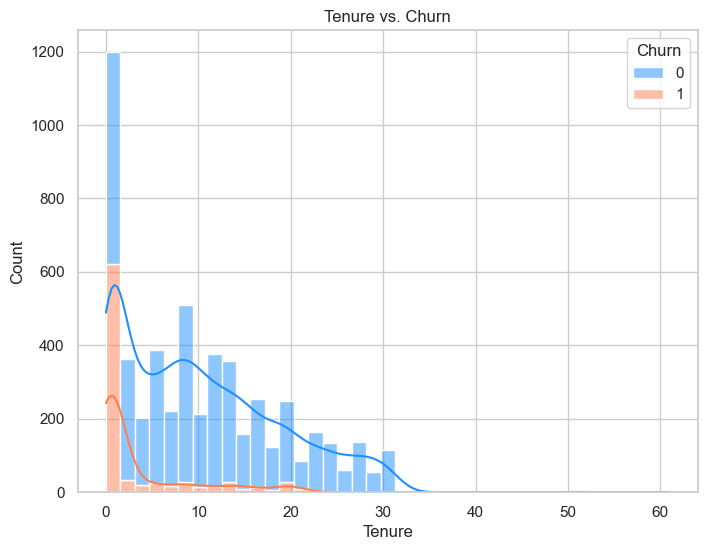

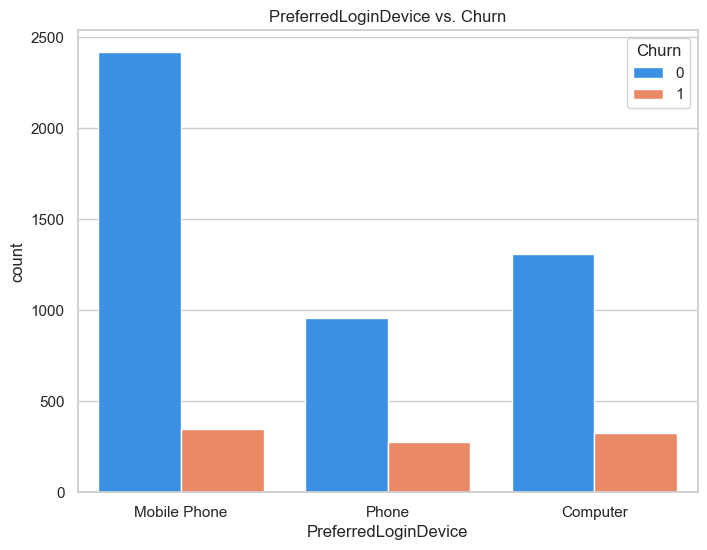

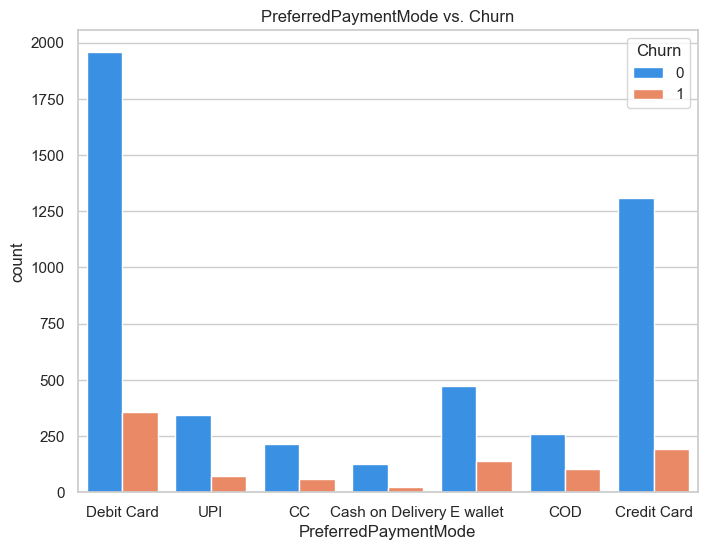

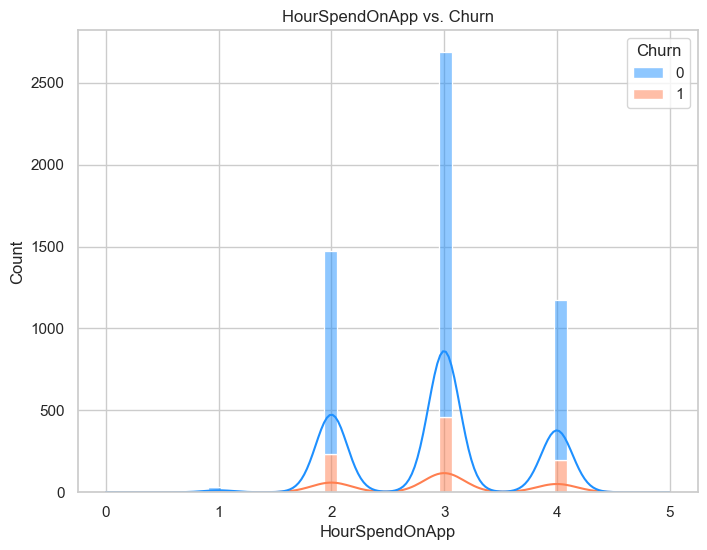

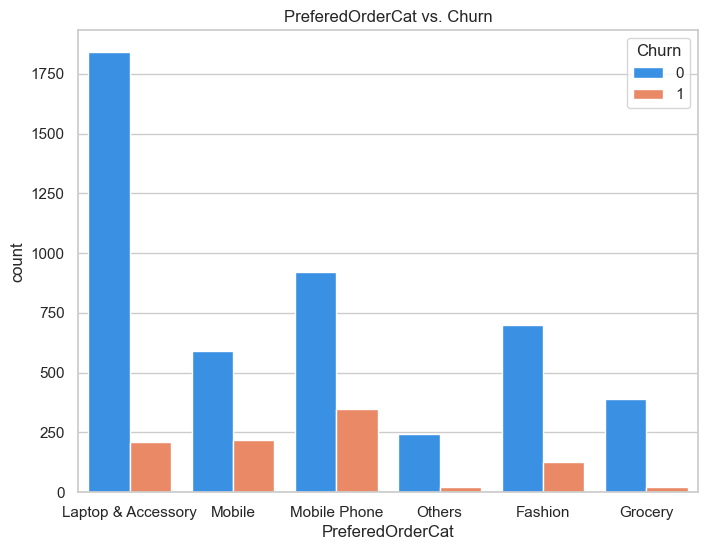

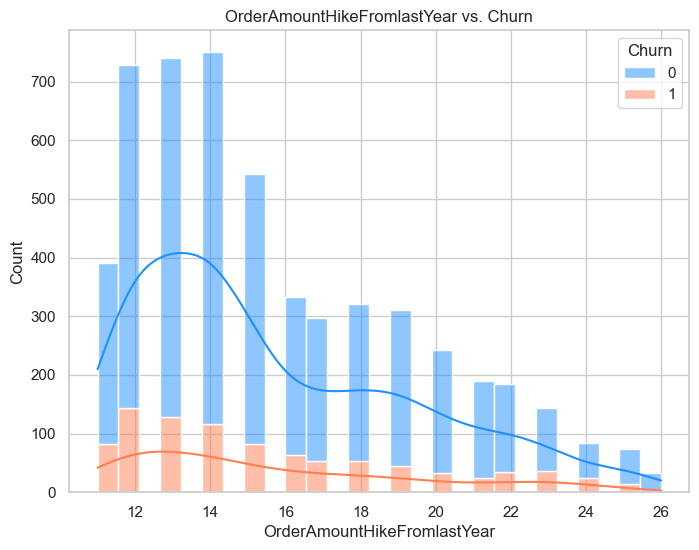

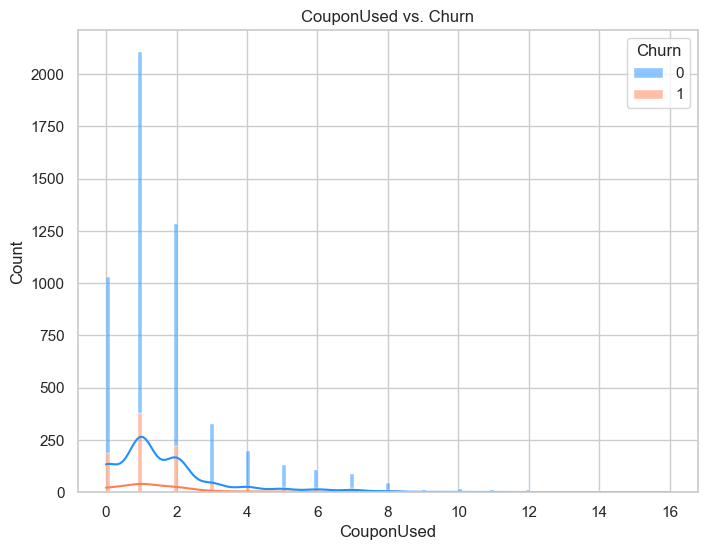

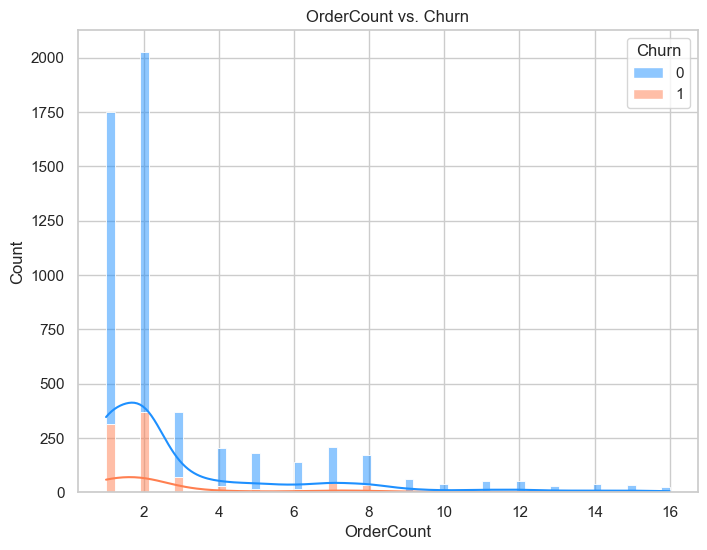

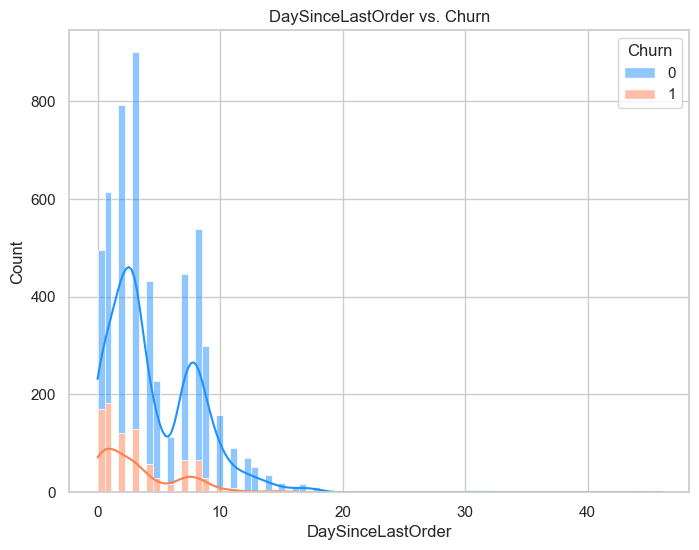

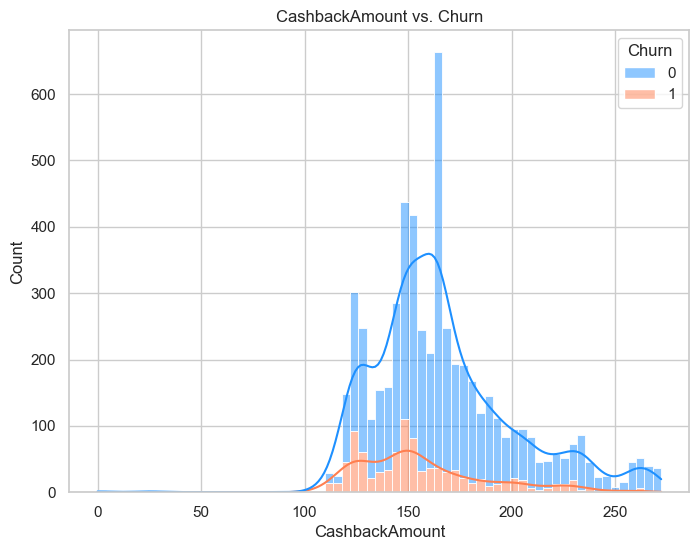

In [48]:
# Define custom color palette
color_theme = ['#1E90FF', '#FF7F50']

# Loop over the features in the 'customer_behv' dataframe and plot data based on datatype
for feature in data[customer_behv].columns:
    # Check the datatype of the feature
    if data[feature].dtype == 'object':
        # Create a countplot for categorical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.countplot(data=data, x=feature, hue='Churn', dodge=True)
        plt.title(f'{feature} vs. Churn')
    else:
        # Create a histogram with kernel density estimate for numerical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.histplot(data=data, x=feature, hue='Churn', multiple='stack', kde=True)
        plt.title(f'{feature} vs. Churn')
    plt.show()


Insights:

**Tenure**: Higher churn rates are observed among new customers with a tenure of 0.

**PreferredLoginDevice**: There is no significant difference in churn rates across various login devices.

**PreferredPaymentMethod**: Customers paying with debit cards tend to have a higher churn rate.

**HoursSpentOnApp**: Customers who spend approximately 3 hours using the app show a higher churn rate.

**PreferredOrderCategory**: Customers who prefer mobile phone orders have a higher churn rate.

**OrderAmountHikeFromLastYear**: Churn rates are higher among customers with order amount hikes of 12 and 14 from the previous year.

**CouponUsed**: Customers using only one coupon tend to have a higher churn rate.

**OrderCount**: Customers placing orders for 2 items show a higher churn rate.

**DaysSinceLastOrder**: Higher churn rates are observed among customers who placed orders within the last 1 day.

**CashbackAmount**: Customers spending around $150 in cashback amount have a higher churn rate.

**Customer Compliance Exploratory**

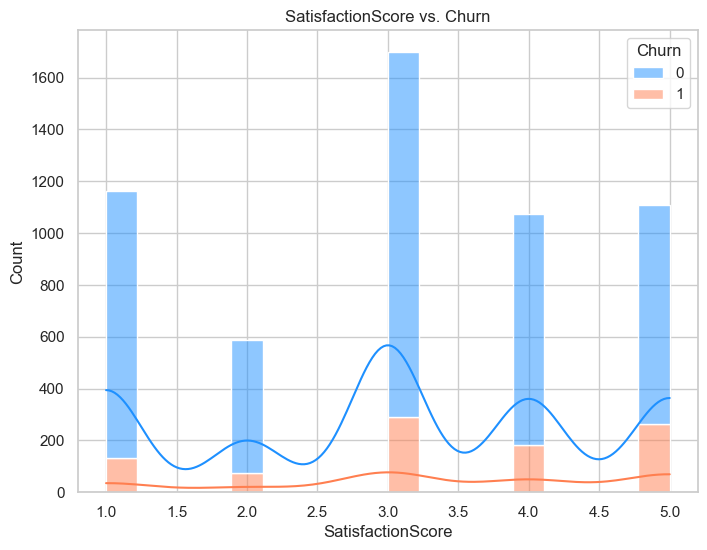

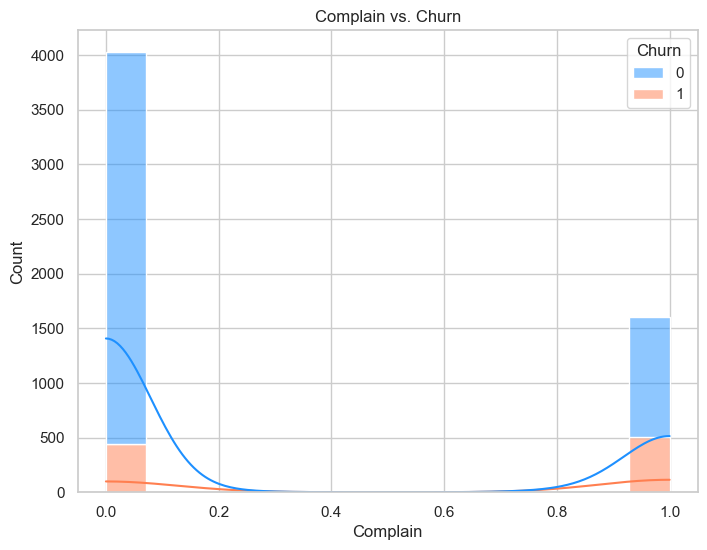

In [49]:
# Define custom color palette
color_theme = ['#1E90FF', '#FF7F50']

# Plotting features in the "custcompl" dataframe with respect to the target variable "Churn"
for feature in data[customer_compl].columns:
    # Check if the feature data type is object
    if data[feature].dtype == 'object':
        # Create a countplot using seaborn library for categorical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.countplot(data=data, x=feature, hue='Churn', dodge=True)
        plt.title(f'{feature} vs. Churn')
    else:
        # Create a histogram with kernel density estimate for numerical features
        plt.figure(figsize=(8, 6))
        sns.set_palette(color_theme)
        sns.histplot(data=data, x=feature, hue='Churn', multiple='stack', kde=True)
        plt.title(f'{feature} vs. Churn')
        plt.show()

Insights:

**SatisfactionScore**: Customers who gave a satisfaction score of 3.0 were more likely to churn.

**Complain**: Customers who filed complaints were more likely to churn.

**Correlation**

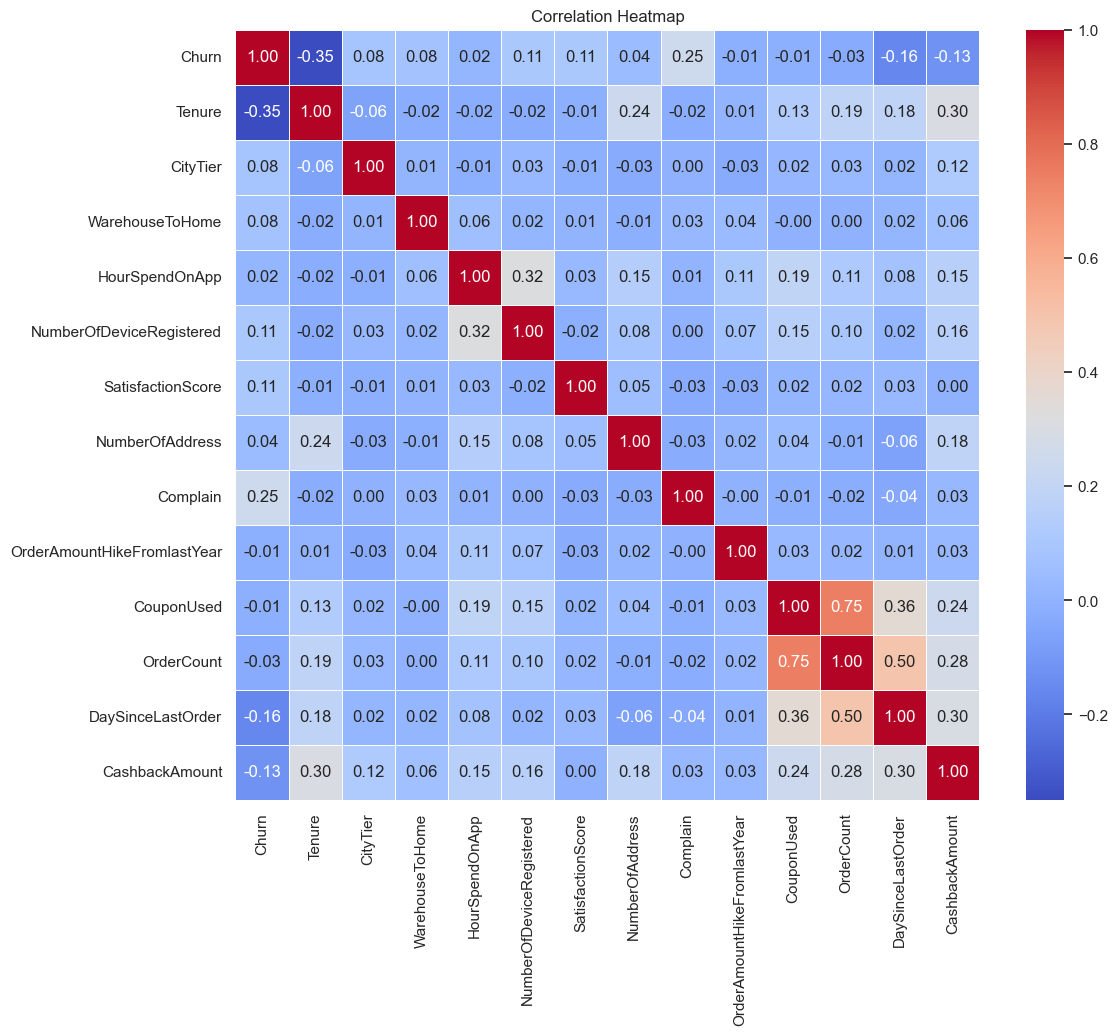

In [89]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Plotting the correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_data.corr()
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)

# Displaying the heatmap
plt.title("Correlation Heatmap")
plt.show()


Insights:

**Positive Correlation**:
There is a noticeable positive correlation (0.25) between the 'Complain' feature and 'Churn.' This indicates that customers who have lodged complaints are more likely to churn, suggesting that addressing customer complaints may be crucial in reducing churn rates."

**Negative Correlation**:
We observe negative correlations between 'Tenure,' 'DaysSinceLastOrder,' 'CashbackAmount,' and 'Churn' with coefficients of -0.34, -0.16, and -0.12, respectively. These correlations suggest that longer tenures, shorter durations since the last order, and higher cashback amounts are associated with reduced churn rates. In other words, customers with longer tenures, recent transactions, and higher cashback amounts are less likely to churn.

**Weak Or No Correlation**:
Interestingly, there seems to be no significant correlation between 'CouponUsed,' 'OrderCount,' 'OrderAmountHikeFromLastYear,' and 'Churn,' with correlation coefficients close to zero (-0.00, -0.02, -0.01). This implies that changes in these variables do not show a linear relationship with customer churn. Further analysis might be needed to understand the factors influencing churn in these cases.

**Data Preprocessing**

As we have already addressed the data cleaning steps at the beginning, which involved removing unwanted data points, handling missing data, and resolving outliers, we will now proceed with further data preprocessing steps. This is to ensure that the data is in a suitable format and of high quality for analysis and modeling.

**Handling Imbalanced Dataset**

In [90]:
churn_count = (data['Churn'] == 1).sum()
no_churn_count = (data['Churn'] == 0).sum()
print(churn_count)
print(no_churn_count)

948
4682


As we can see from the output above, the dataset 'Churn' feature only had 948 (16.8%) customer churn with total 5.630 customers, this make our 'Churn' feature imbalance. In this case, we will apply oversampling method to balance the dataset.

In [91]:
from sklearn.utils import resample

# Separate data into two classes
data_churn = data[data['Churn'] == 1]
data_no_churn = data[data['Churn'] == 0]

# Count the number of samples in each class
count_churn = len(data_churn)
count_no_churn = len(data_no_churn)

# Applying oversampling to balance the dataset
data_oversampled = resample(data_churn, replace=True, n_samples=count_no_churn, random_state=42)

# Combine the oversampled churn data with the no-churn data
balanced_data = pd.concat([data_oversampled, data_no_churn])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=52)
balanced_data.reset_index(drop=True, inplace=True)

In [92]:
# Check total of churn data after apply oversampling method
balanced_data['Churn'].value_counts()

Churn
0    4682
1    4682
Name: count, dtype: int64

Now, we have already performed oversampling method and we can see that the total number of churn and not churn are same in our dataset

**Feature Scaling**

In [93]:
#changing the datatype of 'Churn' columns as it is shown as integer before
balanced_data['Churn'] = balanced_data['Churn'].astype('object')

After critically reviewed from the correlation heatmap just now, we will drop those weak or even no relationship with our target variable

In [94]:
useful_columns=[
    'Churn',
    'Tenure',
    'PreferredLoginDevice',
    'CityTier',
    'PreferredPaymentMode',
    'Gender',
    'NumberOfDeviceRegistered',
    'PreferedOrderCat',
    'SatisfactionScore',
    'MaritalStatus',
    'NumberOfAddress',
    'Complain',
    'CashbackAmount'
]

In [95]:
# Select the relevant columns from the balanced_data DataFrame
selected_data = balanced_data[useful_columns]

In [108]:
from sklearn.preprocessing import StandardScaler

# Make a safe copy of the DataFrame
selected_data = selected_data.copy()

# Identify the numeric columns for feature scaling
numeric_columns = selected_data.select_dtypes(include=['int', 'float']).columns

# Apply StandardScaler to the numeric columns
scaler = StandardScaler()
selected_data[numeric_columns] = scaler.fit_transform(selected_data[numeric_columns])

In [97]:
#save the file into a new variable
data_new = selected_data

In [98]:
data_new.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,CashbackAmount
0,0,0.177225,Computer,1.378146,E wallet,Female,1.169308,Fashion,-1.601369,Married,0.630720,1.278584,1.926444
1,1,-0.918747,Mobile Phone,-0.766604,Debit Card,Male,0.200077,Laptop & Accessory,-0.145876,Married,-0.121022,1.278584,-0.119144
2,0,-0.796973,Mobile Phone,-0.766604,Debit Card,Female,0.200077,Mobile Phone,0.581871,Single,-0.496893,1.278584,-0.394789
3,0,1.151423,Computer,1.378146,E wallet,Female,-0.769154,Laptop & Accessory,-0.145876,Married,1.382461,-0.782115,-0.456500
4,0,0.177225,Computer,-0.766604,Debit Card,Male,0.200077,Laptop & Accessory,-0.145876,Single,-0.496893,1.278584,0.125645


Now, all the numerical columns have undergone feature scaling, ensuring that they are now in a standard format and ready for further analysis and modeling. This preprocessing step enhances the consistency and quality of the data, making it well-suited for machine learning algorithms

**Feature Encoding**

In this step, we use the LabelEncoder to transform categorical attributes such as 'Gender' and 'Churn' into numerical labels as these two columns only have two unique values which are 1 and 0

In [109]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid SettingWithCopyWarning
data_new = data_new.copy()

# Apply Label Encoding
le = LabelEncoder()
data_new['Gender'] = le.fit_transform(data_new['Gender'])
data_new['Churn'] = le.fit_transform(data_new['Churn'])


In [100]:
data_new.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,CashbackAmount
0,0,0.177225,Computer,1.378146,E wallet,0,1.169308,Fashion,-1.601369,Married,0.630720,1.278584,1.926444
1,1,-0.918747,Mobile Phone,-0.766604,Debit Card,1,0.200077,Laptop & Accessory,-0.145876,Married,-0.121022,1.278584,-0.119144
2,0,-0.796973,Mobile Phone,-0.766604,Debit Card,0,0.200077,Mobile Phone,0.581871,Single,-0.496893,1.278584,-0.394789
3,0,1.151423,Computer,1.378146,E wallet,0,-0.769154,Laptop & Accessory,-0.145876,Married,1.382461,-0.782115,-0.456500
4,0,0.177225,Computer,-0.766604,Debit Card,1,0.200077,Laptop & Accessory,-0.145876,Single,-0.496893,1.278584,0.125645


For other categorical data, we will use get_dummies method for feature encoding

In [101]:
data_new = pd.get_dummies(data_new)

In [102]:
data_new.head()

,Churn,Tenure,CityTier,Gender,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,CashbackAmount,PreferredLoginDevice_Computer,...,PreferredPaymentMode_UPI,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,0.177225,1.378146,0,1.169308,-1.601369,0.630720,1.278584,1.926444,True,...,False,True,False,False,False,False,False,False,True,False
1,1,-0.918747,-0.766604,1,0.200077,-0.145876,-0.121022,1.278584,-0.119144,False,...,False,False,False,True,False,False,False,False,True,False
2,0,-0.796973,-0.766604,0,0.200077,0.581871,-0.496893,1.278584,-0.394789,False,...,False,False,False,False,False,True,False,False,False,True
3,0,1.151423,1.378146,0,-0.769154,-0.145876,1.382461,-0.782115,-0.456500,True,...,False,False,False,True,False,False,False,False,True,False
4,0,0.177225,-0.766604,1,0.200077,-0.145876,-0.496893,1.278584,0.125645,True,...,False,False,False,True,False,False,False,False,False,True


**Building ML Prediction Model**

Now, we have successfully completing the data preprocessing phase, we are now ready to move forward into the exciting phase of constructing our machine learning models.

In this section, I will implementing Logistic Regression, KNN ,SVC and Naive Bayes to compare each model and to see which model have the better accuracy to predict customer churn.

First we need to the data into 80% training dataset and 20% testing dataset


In [103]:
#Separating features (X) and target variable (y)
X = data_new.drop(['Churn'], axis=1)
y = data_new['Churn']

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Logistic Regression**

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Create and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_imputed, y_train)

# Step 3: Predict churn on the test data
y_pred = logistic_model.predict(X_test_imputed)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy Score:", accuracy)
print("\nClassification Report:\n", report)


Accuracy Score: 0.800320341697811

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80       958
           1       0.79      0.80      0.80       915

    accuracy                           0.80      1873
   macro avg       0.80      0.80      0.80      1873
weighted avg       0.80      0.80      0.80      1873



The logistic regression model achieved an accuracy of approximately 79.77%, indicating that it correctly predicted the churn status for nearly 80% of the samples. The model displays balanced performance, with similar metrics for both classes, with f1-scores around 0.80, suggesting a robust model performance. The macro and weighted average metrics also hover around 0.80, affirming the model's overall effectiveness in classifying customer churn, making it a promising candidate for churn prediction. Overall, it demonstrates good predictive capability for identifying customer churn

**K-Nearest Neighbour(KNN)**

In [105]:
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_imputed, y_train)

# Step 3: Predict churn on the test data
y_pred_knn = knn_model.predict(X_test_imputed)

# Step 4: Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)

print("Accuracy Score (KNN):", accuracy_knn)
print("\nClassification Report (KNN):\n", report_knn)


Accuracy Score (KNN): 0.9418045915643353

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       958
           1       0.90      0.99      0.94       915

    accuracy                           0.94      1873
   macro avg       0.95      0.94      0.94      1873
weighted avg       0.95      0.94      0.94      1873



The K-Nearest Neighbors (KNN) model exhibits strong predictive performance with an accuracy score of approximately 94.13%, indicating its ability to correctly classify customer churn. The classification report highlights high precision and recall values for both churn and non-churn categories, signifying balanced model effectiveness. Comparing it to the Logistic Regression model's accuracy of around 79.77%, the KNN model outperforms by a significant margin, emphasizing its superiority in making churn predictions.

**Support Vector Machine (SVM)**

In [106]:
from sklearn.svm import SVC

# Step 1: Handle missing values (only if you haven't already done this)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Create and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_imputed, y_train)

# Step 3: Predict churn on the test data
y_pred_svm = svm_model.predict(X_test_imputed)

# Step 4: Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("Accuracy Score (SVM):", accuracy_svm)
print("\nClassification Report (SVM):\n", report_svm)


Accuracy Score (SVM): 0.803523758675921

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.81      0.80      0.81       958
           1       0.80      0.81      0.80       915

    accuracy                           0.80      1873
   macro avg       0.80      0.80      0.80      1873
weighted avg       0.80      0.80      0.80      1873



The SVM (Support Vector Machine) model achieved an accuracy score of 0.8003, similar to the logistic regression model's accuracy of 0.7977. Both models demonstrate comparable performance in correctly classifying instances of customer churn but not as good as K-Nearest Neighbour(KNN). In terms of precision, recall, and F1-score, the SVM model also closely mirrors the results of the logistic regression model, with balanced precision and recall for both churn and non-churn cases. This indicates that the SVM model effectively distinguishes between churn and non-churn customers, making it a viable alternative to logistic regression for your churn prediction task.

**Naive Bayes Classifier**

In [84]:
from sklearn.naive_bayes import GaussianNB

# Step 1: Handle missing values (skip this if you've already imputed these earlier)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Create and train the Naive Bayes model
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_imputed, y_train)

# Step 3: Predict churn on the test data
y_pred_naive_bayes = naive_bayes_model.predict(X_test_imputed)

# Step 4: Evaluate the model
accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
report_naive_bayes = classification_report(y_test, y_pred_naive_bayes)

print("Accuracy Score (Naive Bayes):", accuracy_naive_bayes)
print("\nClassification Report (Naive Bayes):\n", report_naive_bayes)


Accuracy Score (Naive Bayes): 0.7095568606513615

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.76      0.63      0.69       958
           1       0.67      0.79      0.73       915

    accuracy                           0.71      1873
   macro avg       0.72      0.71      0.71      1873
weighted avg       0.72      0.71      0.71      1873



The Naive Bayes classifier achieved an accuracy score of approximately 0.709, indicating that it correctly predicted the churn outcome for about 70.9% of the test data. The precision and recall scores for both churn (1) and non-churn (0) classes are relatively balanced, with some trade-off between precision and recall. The model has a slightly higher recall for the non-churn class, suggesting it is better at identifying non-churn instances, while the precision for the churn class is somewhat higher, indicating a relatively better positive predictive value. The F1-scores are around 0.69 and 0.73 for non-churn and churn classes, respectively. These scores suggest that the Naive Bayes model provides a decent but not outstanding performance in predicting customer churn in this dataset.

**Conclusion**

After building and testing four machine learning models, we have obtained the following results:

**Logistic Regression:**
Accuracy Score: 0.7977
Churn Precision: 0.79
Churn Recall: 0.80

**K-Nearest Neighbor (KNN):**
Accuracy Score: 0.9413
Churn Precision: 0.90
Churn Recall: 0.99

**Support Vector Machine (SVM):**
Accuracy Score: 0.8003
Churn Precision: 0.79
Churn Recall: 0.81

**Naive Bayes:**
Accuracy Score: 0.7090
Churn Precision: 0.67
Churn Recall: 0.79

These results indicate that the K-Nearest Neighbor (KNN) model outperforms the other models, achieving the highest accuracy and precision. It provides a reliable method for predicting customer churn, with an accuracy score of approximately 94.13%. On the other hand, Logistic Regression, Support Vector Machine (SVM), and Naive Bayes offer decent performance with accuracy scores of approximately 79.77%, 80.03%, and 70.90%, respectively. Hence, the KNN model is recommended for the most accurate customer churn predictions.